### **Análisis Exploratorio de los datos**

#### **Cargue del Dataframe, limpieza e imputaciones**

In [1]:
# Importación de Librerías y lectura del Dataframe
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from functions.functions import RegresionLogistica, RegresionLogisticaLasso, RegresionLogisticaRidge, RegresionElasticNet, LogisticRegression

In [2]:
dir = 'resources/Dengue_Data.xlsx'
df = pd.read_excel(dir,engine='openpyxl',sheet_name = 'datos')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50397 entries, 0 to 50396
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   edad_                          50397 non-null  int64  
 1   Grupos edad                    50397 non-null  object 
 2   sexo_                          50397 non-null  object 
 3   area_1                         50397 non-null  object 
 4   area_2                         50397 non-null  object 
 5   area_                          50397 non-null  object 
 6   ocupacion_                     50397 non-null  object 
 7   per_etn_                       50397 non-null  object 
 8   gp_discapa                     49661 non-null  object 
 9   gp_desplaz                     49676 non-null  object 
 10  gp_migrant                     49696 non-null  object 
 11  gp_carcela                     49681 non-null  object 
 12  gp_gestan                      24841 non-null 

Number of object columns: 42


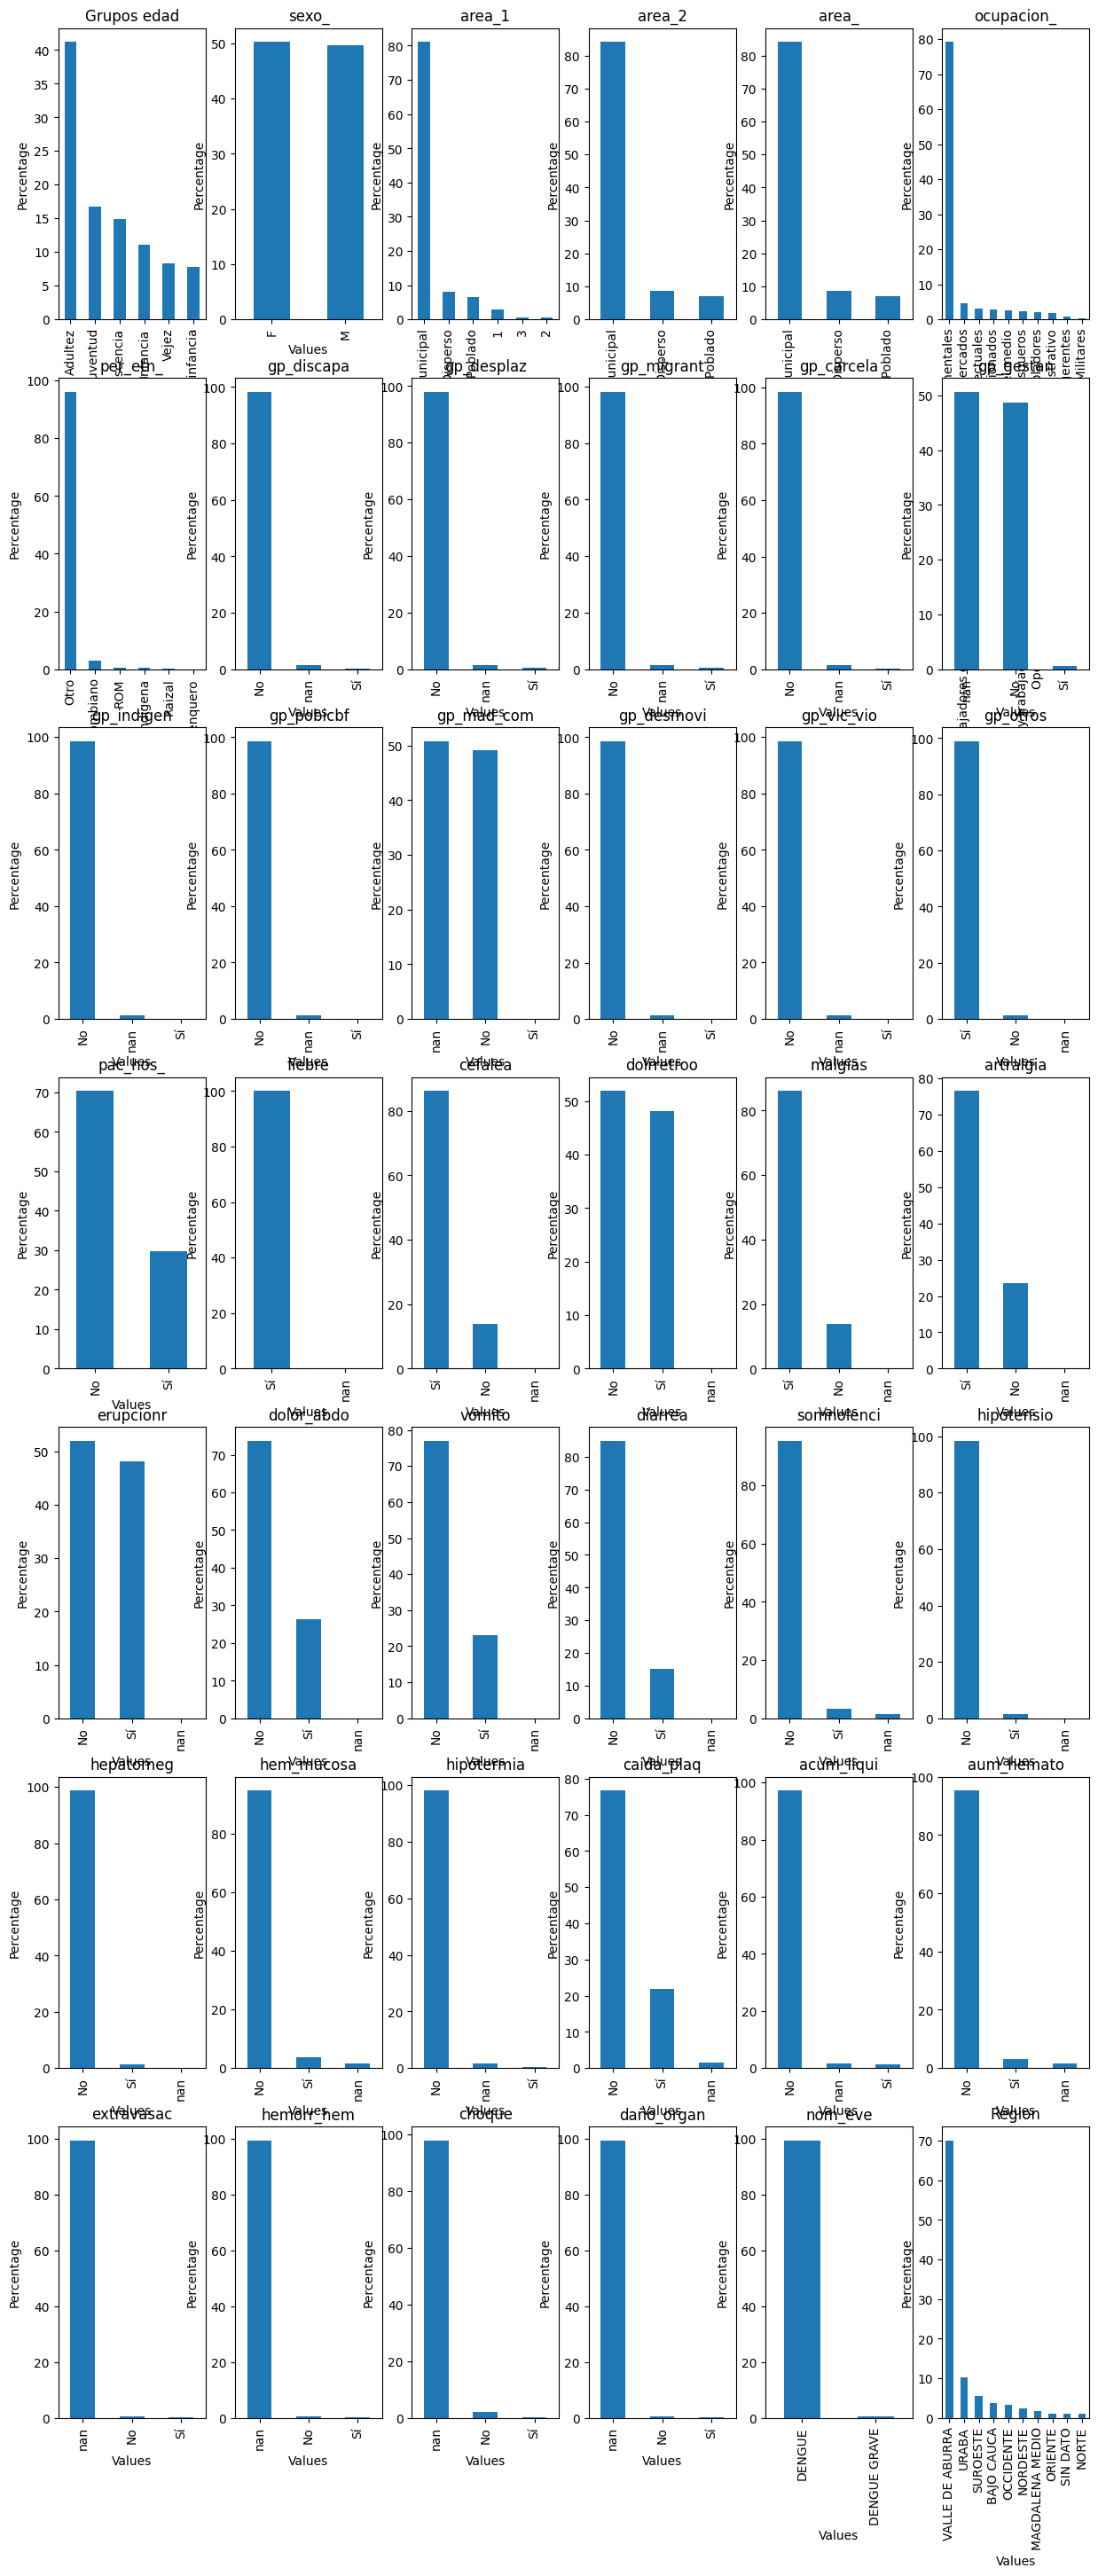

In [3]:
# Identificar columnas de tipo object
object_columns = df.select_dtypes(include=['object']).columns
print(f"Number of object columns: {len(object_columns)}")

# Calcular el número de filas y columnas para la matriz de subplots
num_cols = 6  # Número de columnas en la matriz de subplots
num_rows = (len(object_columns) + num_cols - 1) // num_cols  # Número de filas en la matriz de subplots

# Crear gráficos de porcentaje para cada columna de tipo object en una matriz de subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar la iteración

for i, col in enumerate(object_columns):
    value_counts = df[col].value_counts(dropna=False)
    percentage = (value_counts / len(df)) * 100
    percentage.plot(kind='bar', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel('Percentage')
    axes[i].set_xlabel('Values')

# Eliminar subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
del axes, col, fig, num_cols, num_rows, object_columns, percentage, value_counts, i # Eliminar variables no necesarias

Se puede observar que la mayoria de variables son Categóricas. Se identifica y seleccionan las variables relevantes dentro de los 2 grupos (variables socio-demográficas y variables clínicas). 

Las siguientes columnas se eliminan bajo los siguientes criterios:
- **area_1**: Misma información de la columna area.
- **area_2**: Misma información de la columna area.
- **gp_mad_com**: No se tiene contexto sobre la columna y el 51% de los datos estan vacíos.
- **tpo_consulta(consulta-inicio)**: No se tiene contexto sobre la columna.
- **fiebre**: 99,98% de los datos estan marcados como SI, los demás vacíos, lo que indica que sobre todas las personas que hacen parte de la muestra tienen fiebre y al no tener variabilidad sobre esta columna no influye / impacta sobre el modelo.
- **extravasac**: El 99% de la columna viene vacia y no hay criterio claro para imputación.
- **hemorr_hem**: El 99% de la columna viene vacia y no hay criterio claro para imputación.

In [4]:
# Columnas innecesarias
col_eliminar = ['area_1', 'area_2', 'gp_mad_com', 'tpo_consulta(consulta-inicio)', 'fiebre', 'extravasac', 'hemorr_hem']
# Columnas de interés separadas por categorías
col_soc_demograficas = ['edad',
                        'Grupos edad',
                        'sexo', 'area',
                        'ocupacion',
                        'per_etn',
                        'gp_discapa',
                        'gp_desplaz',
                        'gp_migrant',
                        'gp_gestan',
                        'gp_pobicbf',
                        'gp_desmovi',
                        'gp_vic_vio',
                        'gp_otros']
col_clinicas = ['fec_con',
                'ini_sin',
                'pac_hos',
                'fec_hos',
                'tpo_deterioro(hosp-consul)',
                'cefalea',
                'dolrretroo',
                'malgias','artralgia',
                'erupcionr',
                'dolor_abdo',
                'vomito',
                'diarrea',
                'somnolenci',
                'hipotensio',
                'hepatomeg',
                'hem_mucosa',
                'hipotermia',
                'caida_plaq',
                'acum_liqui',
                'aum_hemato',
                'choque',
                'daño_organ']

# Alistamiento del Dataset
df.rename(columns=lambda x: x.rstrip('_'), inplace=True)
df.drop(inplace=True,columns=col_eliminar) # Eliminar columnas innecesarias

# Imputación de valores faltantes
df.loc[(df['sexo'] == 'M') & (df['gp_gestan'].isnull()), 'gp_gestan'] = 'No'        # Se reemplazan los valores nulos de gp_gestan por 'No' si el sexo es Masculino

### **Parte A - Predecir Dengue o Dengue Grave a partir de Variables Socio-demográficas**

#### **Depuración del Dataframe**
Inicialmente, se depuran las columnas de interés y se eliminan registros vacíos para el estudio 

In [5]:
df1 = df.copy() # Crear una copia del DataFrame original
df1.drop(inplace=True,columns=col_clinicas) # Eliminar columnas innecesarias
print(f'Registros del Dataframe Original: {df1.shape[0]}')

# Eliminar registros con datos nulos
df1.dropna(inplace=True)
print(f'Registros del Dataframe Eliminando nulos en columnas de interés: {df1.shape[0]}')


Registros del Dataframe Original: 50397
Registros del Dataframe Eliminando nulos en columnas de interés: 49475


#### **Dummificación de variables categoricas (binarias, ordinales y nominales)**


In [6]:
col_binarias = ['sexo', 'gp_discapa', 'gp_desplaz', 'gp_migrant', 'gp_carcela', 'gp_gestan', 'gp_indigen', 'gp_pobicbf', 'gp_desmovi', 'gp_vic_vio', 'gp_otros','nom_eve']
col_ordinales = ['Grupos edad']	
col_nominales = ['area', 'ocupacion', 'per_etn', 'Region']

print(f'Dimensionalidad del Dataframe ANTES de aplicar label / One hot encoding: {df1.shape}')
# Label Encoding para columnas binarias
le = LabelEncoder()
for col in col_binarias:
    df1[col] = le.fit_transform(df1[col])

# Label Encoding para Grupos Edad
orden = ['Primera infancia', 'Infancia', 'Adolescencia', 'Juventud', 'Adultez', 'Vejez']
le_ordinal = LabelEncoder()
le_ordinal.fit(orden)
df1['Grupos edad'] = le_ordinal.transform(df1['Grupos edad'])

df1 = pd.get_dummies(df1, columns=col_nominales, dtype=int)
del le, le_ordinal, col_binarias, col_nominales, col_ordinales, orden, col # Eliminar variables no necesarias
print(f'Dimensionalidad del Dataframe DESPUÉS de aplicar label / One hot encoding: {df1.shape}')

Dimensionalidad del Dataframe ANTES de aplicar label / One hot encoding: (49475, 18)
Dimensionalidad del Dataframe DESPUÉS de aplicar label / One hot encoding: (49475, 43)


#### **Dataset de Prueba y de entrenamiento**

In [7]:
#dividir el dataset en entrenamiento y prueba

X = df1.drop(columns=['nom_eve'])
y = df1['nom_eve']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
# Ajustar y transformar los datos de entrenamiento y prueba
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Como necesitamos llamar a los modelos de regresión logistica y evaluarlos múltiples veces, tomamos la estrategia de crear 4 clases para cada uno de los modelos y establecer dentro de las clases unas métricas de evaluación y la generación de la matriz de confusión, estas clases se llaman al inicio del Script y se pueden ven en el archivo [functions.py](functions/functions.py), al inicio se observa de la siguiente manera:
```python
from functions.functions import RegresionLogistica, RegresionLogisticaLasso, RegresionLogisticaRidge, RegresionElasticNet
```

Accuracy: 1.00
Kappa: 0.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9848
           1       0.00      0.00      0.00        47

    accuracy                           1.00      9895
   macro avg       0.50      0.50      0.50      9895
weighted avg       0.99      1.00      0.99      9895



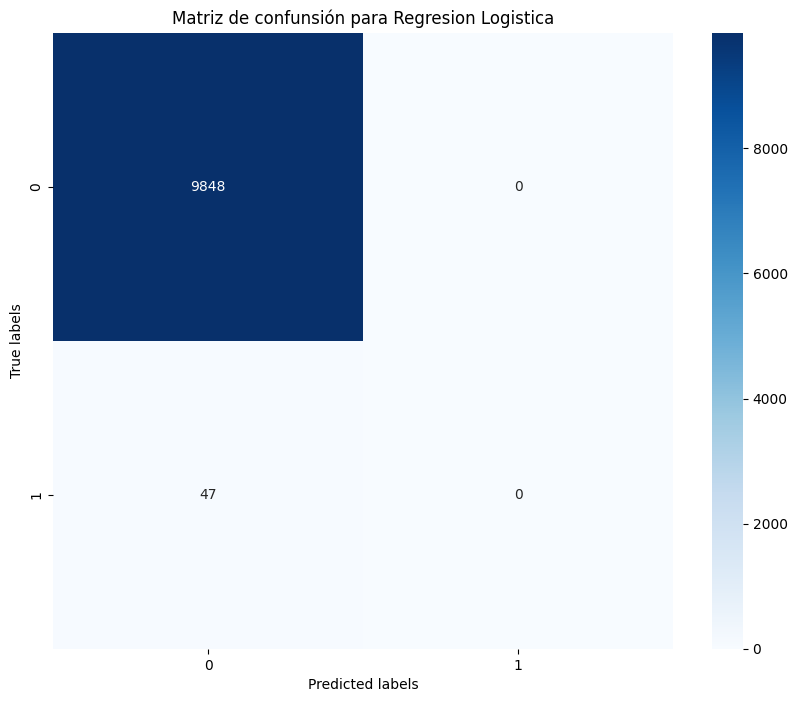

In [8]:
# Instanciar el Objeto RegresionLogistica
rl = RegresionLogistica()
rl.fit_model(X_train_scaled, y_train)
y_pred_rl = rl.predict(X_test_scaled)
rl.evaluate(y_test, y_pred_rl)                     # Evaluar el modelo
rl.plot_confusion_matrix(y_test, y_pred_rl)        # Matriz de confusión

Accuracy: 1.00
Kappa: 0.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9848
           1       0.00      0.00      0.00        47

    accuracy                           1.00      9895
   macro avg       0.50      0.50      0.50      9895
weighted avg       0.99      1.00      0.99      9895



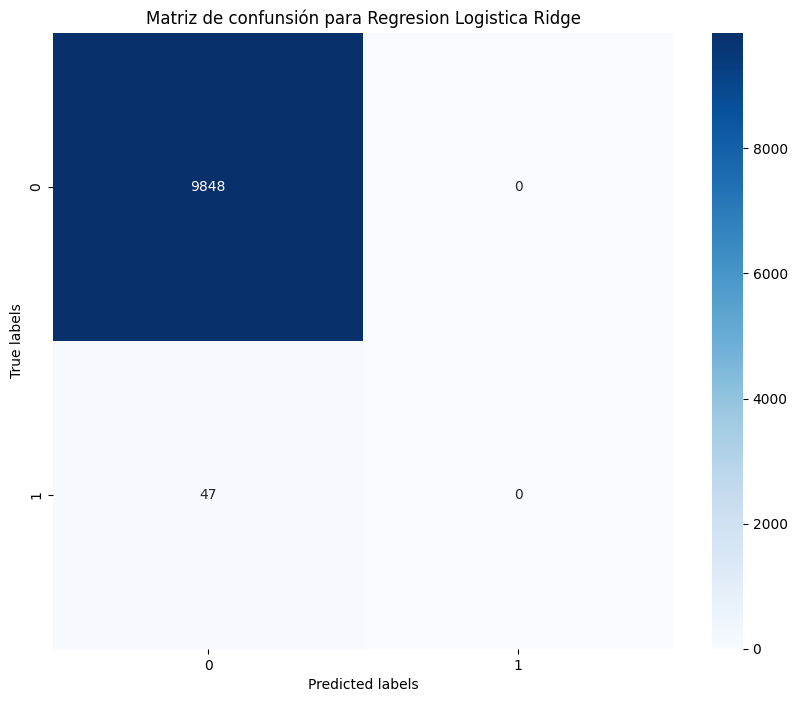

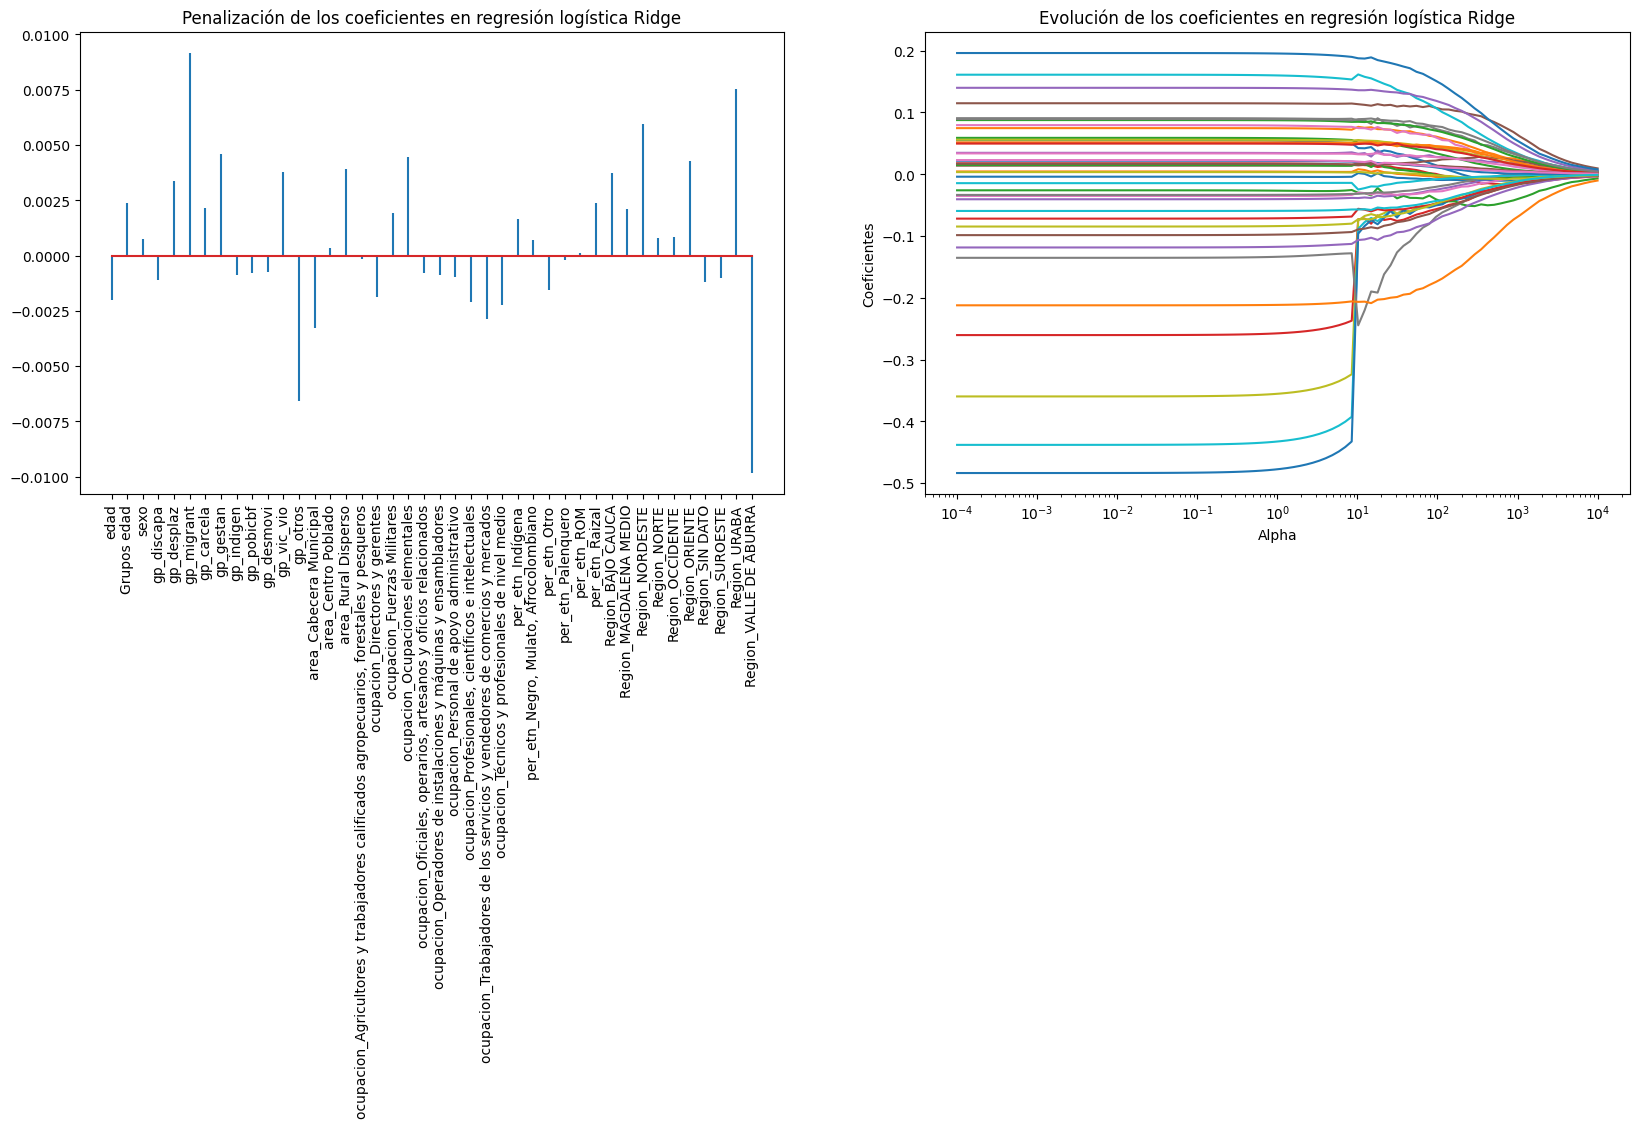

In [9]:
# Instanciar el Objeto RegresionLogistica Ridge
cs = np.logspace(-4, 4, 100)                            # Definir los valores de alpha
rl1 = RegresionLogisticaRidge(Cs = cs)
rl1.fit_model(X_train_scaled, y_train)
y_pred_lasso = rl1.predict(X_test_scaled)
rl1.evaluate(y_test, y_pred_lasso)                     # Evaluar el modelo
rl1.plot_confusion_matrix(y_test, y_pred_lasso)        # Matriz de confusión

# Obtener los coeficientes para cada valor de alpha
ridge_coefs = []
for a in cs:
    ridge = LogisticRegression(penalty='l2', C=1/a, solver='lbfgs', random_state=42)
    ridge.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge.coef_.flatten())  # Aplanar los coeficientes y agregarlos a la lista

ridge_coefs = np.array(ridge_coefs)  # Convertir la lista en un arreglo de numpy bidimensional (100, n_coeficientes)

# Coeficientes del modelo Ridge con el alpha óptimo y los predictores seleccionados
df_coeficientes_Ridge = pd.DataFrame({
    "predictores": X_train.columns,
    "coeficientes": rl1.coefs().flatten()
    })

df_coeficientes_Ridge = df_coeficientes_Ridge.query("coeficientes != 0")
#print(df_coeficientes_Ridge)

# Generar las gráficas para la evolución de los coeficientes de regresión
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Gráfica para penalización de Coeficientes
axes[0].stem(df_coeficientes_Ridge.predictores, df_coeficientes_Ridge.coeficientes, markerfmt = ' ')
axes[0].set_xticks(df_coeficientes_Ridge.predictores)
axes[0].set_xticklabels(df_coeficientes_Ridge.predictores, rotation = 90)
axes[0].set_title('Penalización de los coeficientes en regresión logística Ridge')
# Gráfica para coeficientes vs Alpha
axes[1].plot(cs, ridge_coefs)
axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coeficientes')
axes[1].set_title('Evolución de los coeficientes en regresión logística Ridge')
axes[1].axis('tight')

plt.tight_layout()
plt.show()

### **Conclusión de los Resultados Obtenidos en la Matriz de Confusión**

La matriz de confusión nos permite evaluar el desempeño de los modelos de regresión logística en la clasificación de los casos de Dengue y Dengue Grave. A continuación, se presentan las conclusiones basadas en los resultados obtenidos:

1. **Exactitud del Modelo**:
    - La exactitud del modelo se puede observar en la diagonal principal de la matriz de confusión, donde se encuentran los verdaderos positivos (TP) y los verdaderos negativos (TN). Un alto número en estos valores indica que el modelo está clasificando correctamente la mayoría de los casos.

2. **Balance de Clases**:
    - Dado que la variable objetivo está desbalanceada, es importante observar cómo el modelo maneja este desbalance. Un buen modelo debe tener un buen desempeño en ambas clases, no solo en la clase mayoritaria.

4. **Cohen's Kappa**:
    - El valor de Cohen's Kappa proporciona una medida de la concordancia entre las predicciones del modelo y las verdaderas etiquetas, ajustada por la concordancia que podría ocurrir por azar. Un valor alto de Kappa indica una buena concordancia.

In [ ]:
####################################################################################################################################
## RODRI POR ACA VAMOS                                                                                                            ## 
####################################################################################################################################
# Instanciar el Objeto RegresionLogistica Lasso
cs = np.logspace(-2, 2, 10)                            # Definir los valores de alpha, se ponen 10 valores por la limitacion computacional
rl1 = RegresionLogisticaLasso(Cs = cs)
rl1.fit_model(X_train_scaled, y_train)
y_pred_lasso = rl1.predict(X_test_scaled)
rl1.evaluate(y_test, y_pred_lasso)                     # Evaluar el modelo
rl1.plot_confusion_matrix(y_test, y_pred_lasso)        # Matriz de confusión

In [ ]:
# Instanciar el Objeto RegresionLogistica ElasticNet

l1_ratios_vector=[0.2, 0.4, 0.6, 0.8, 1]                                # Definir los valores de l1, se ponen 5 valores por la limitacion computacional
cs = np.logspace(-2, 2, 10)                                             # Definir los valores de alpha, se ponen 10 valores por la limitacion computacional
rl1 = RegresionElasticNet(Cs = cs, l1_ratios=l1_ratios_vector)
rl1.fit_model(X_train_scaled, y_train)
y_pred_lasso = rl1.predict(X_test_scaled)
rl1.evaluate(y_test, y_pred_lasso)                                      # Evaluar el modelo
rl1.plot_confusion_matrix(y_test, y_pred_lasso)                         # Matriz de confusión

#### **Balanceo de Dataframe para Entrenar el modelo**
Una vez aplicada la Dummyficación de variables, se procede a analizar la variable objetivo "NOM_EVE"

In [ ]:
df1['nom_eve'].value_counts()

Se puede observar que el Dataset en la variable objetivo se encuentra enormemente desbalanceado, y no significa que esté mal, es el comportamiento natural del fenomeno estudiado, sin embargo, para usos prácticos y mejores resultados del modelo, se opta por balancear el conjunto de datos de Entrenamiento de la siguiente forma:

- **Conjunto de datos de Entrenamiento:**
    - Registros con variable Objetivo 0 (Dengue): 216
    - Registros con variable Objetivo 1 (Dengue Grave): 216 (80% de registros con este valor)

- **Conjunto de datos de Pruebas:**
    - Registros con variable Objetivo 0 (Dengue): 48.989
    - Registros con variable Objetivo 1 (Dengue Grave): 54 (20% de registros con este valor)


In [ ]:
# Dividir los datos en entrenamiento y prueba

# Seleccionar los primeros 216 registros con 'nom_eve' = 0 y 'nom_eve' = 1 

dengue_train = df1[df1['nom_eve'] == 0].sample(n=216, random_state=42)
dengue_grave_train = df1[df1['nom_eve'] == 1].sample(n=216, random_state=42)
train_data = pd.concat([dengue_train, dengue_grave_train])

# Definir X_train y y_train
X_train = train_data.drop(columns=['nom_eve'])
y_train = train_data['nom_eve']

# Calcular Test Data
test_data = df1.drop(train_data.index)
X_test = test_data.drop(columns=['nom_eve'])
y_test = test_data['nom_eve']

# Verificación de balance en el conjunto de entrenamiento y prueba
print("Distribución en el conjunto de entrenamiento:")
print(y_train.value_counts())
print("\nDistribución en el conjunto de prueba:")
print(y_test.value_counts())

del dengue_train, dengue_grave_train, train_data, test_data # Eliminar variables no necesarias

In [ ]:
# Opción 2: Dividir los datos en entrenamiento y prueba usando train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df1.drop(columns=['nom_eve']), df1['nom_eve'], test_size=0.2, random_state=42, stratify=df1['nom_eve'])


Se procede a realizar la estandarizacion de los datos

In [ ]:
scaler = StandardScaler()

# Ajustar y transformar los datos de entrenamiento y prueba
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### **Regresión Logística**

In [ ]:
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, confusion_matrix, accuracy_score

# Crear el modelo de regresión logística
logisticModel = LogisticRegression(penalty = None, l1_ratio=None, random_state=42)
logisticModel.fit(X_train_scaled, y_train)

# Predecir en el conjunto de prueba
y_hat = logisticModel.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_hat)}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_hat)}")

### Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_hat)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Dengue', 'Dengue Grave'], yticklabels=['Dengue', 'Dengue Grave'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### **Regresión Logística - Ridge**

In [ ]:
# Crear el modelo de regresión logística Ridge
logisticModel_Ridge = LogisticRegressionCV(penalty = "l2",
                                           solver = "lbfgs",
                                           cv = 10,
                                           random_state = 42,
                                           max_iter = 1000,
                                           scoring='accuracy',
                                           Cs = np.logspace(-10, 2, 200))
#logisticModel_Ridge = LogisticRegression(penalty = 'l2', solver='lbfgs', l1_ratio=None, random_state=42)

logisticModel_Ridge.fit(X_train_scaled, y_train)

# Predecir en el conjunto de prueba
y_hat_Ridge = logisticModel_Ridge.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_hat_Ridge)}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_hat_Ridge)}")
print(f"Optimal alpha: {logisticModel_Ridge.C_[0]}")

### Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_hat_Ridge)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Dengue', 'Dengue Grave'], yticklabels=['Dengue', 'Dengue Grave'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### **Regresión Logística - Lasso**

In [ ]:
# Crear el modelo de regresión logística Lasso
logisticModel_Lasso = LogisticRegressionCV(penalty = "l1",
                                           solver = "saga",
                                           cv = 10,
                                           random_state = 42,
                                           max_iter = 1000,
                                           scoring='accuracy',
                                           Cs = np.logspace(-10, 2, 200))
#logisticModel_Lasso = LogisticRegression(penalty = 'l1', solver='saga', l1_ratio=None, random_state=42)
logisticModel_Lasso.fit(X_train_scaled, y_train)

# Predecir en el conjunto de prueba
y_hat_Lasso = logisticModel_Lasso.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_hat_Lasso)}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_hat_Lasso)}")
print(f"Optimal alpha: {logisticModel_Lasso.C_[0]}")

### Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_hat_Lasso)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Dengue', 'Dengue Grave'], yticklabels=['Dengue', 'Dengue Grave'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### **Regresión Logística - Elastic Net**

In [ ]:
# Crear el modelo de regresión logística Elastic Net
logisticModel_Enet = LogisticRegressionCV(penalty = "elasticnet",
                                           solver = "saga",
                                           l1_ratios = np.array([0, 0.1, 0.5, 0.8, 0.98, 1]),
                                           cv = 10,
                                           random_state = 42,
                                           max_iter = 1000,
                                           scoring='accuracy',
                                           Cs = np.logspace(-10, 2, 200))
#logisticModel_Enet = LogisticRegression(penalty = 'elasticnet', solver='saga', l1_ratio=None, random_state=42)
logisticModel_Enet.fit(X_train_scaled, y_train)

# Predecir en el conjunto de prueba
y_hat_Enet = logisticModel_Enet.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_hat_Enet)}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_hat_Enet)}")
print(f"Optimal alpha: {logisticModel_Enet.C_[0]}")
print(f"Optimal l1_ratio: {logisticModel_Enet.l1_ratio_[0]}")

### Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_hat_Enet)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Dengue', 'Dengue Grave'], yticklabels=['Dengue', 'Dengue Grave'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()